### Problem statement 

The objective is to classify images of dogs and cats accurately using deep learning techniques. The task involves training two models: a custom neural network and a fine-tuned pre-trained VGG16 model, to compare their effectiveness. The performance evaluation will assess key metrics such as accuracy, precision, recall, F1-score, and analyze specific cases where the models fail. Additionally, the work will focus on the clarity and interpretability of the findings through well-structured code and data exploration.

##  Importing Libaries

In [ ]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
print("GPUs detected:", gpus)

# Attempt to set visible devices if GPUs are detected
if gpus:
    try:
        tf.config.experimental.set_visible_devices([], 'GPU')
    except RuntimeError as e:
        print(e) 

# Now proceed with other imports
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import os
import random
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import optimizers

GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Obtaining the dataset

In [ ]:
data_folder = pathlib.Path('../CSCN8010/data/kaggle_dogs_vs_cats_small')

In [3]:
train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


## EDA

In [ ]:
import os

train_dir = data_folder / "train"

print("Training data:")
for label in os.listdir(train_dir):
    label_path = os.path.join(train_dir, label)
    if os.path.isdir(label_path): 
        print(f"{label}: {len(os.listdir(label_path))} images")

print("Training data:")
for label in os.listdir(train_dir):
    label_path = os.path.join(train_dir, label)
    if os.path.isdir(label_path): 
        print(f"{label}: {len(os.listdir(label_path))} images")


Training data:
cat: 1000 images
dog: 1000 images
Training data:
cat: 1000 images
dog: 1000 images


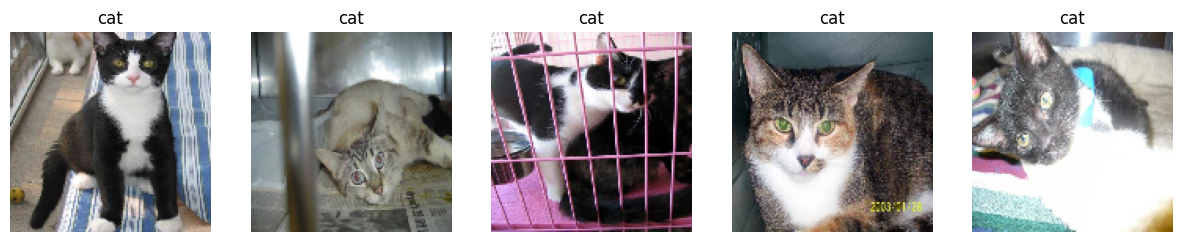

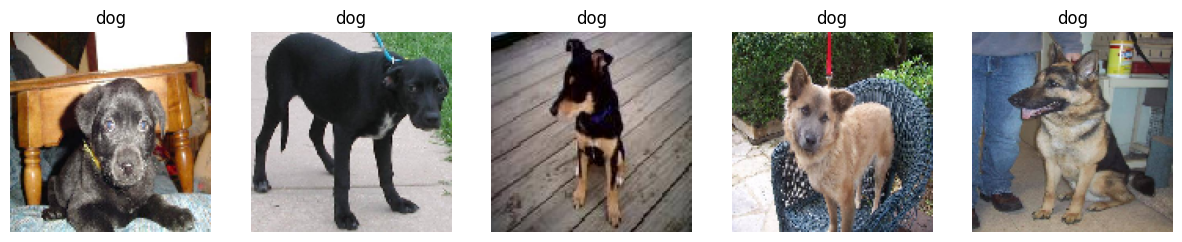

In [ ]:
train_images_dir = os.path.join(data_folder, 'train')  

def plot_sample_images_flat(folder, label, n=5):
    class_folder = os.path.join(folder, label)
    
    # List image files in the subdirectory
    image_files = os.listdir(class_folder)
    
    if len(image_files) < n:
        n = len(image_files)
    
    selected_files = random.sample(image_files, n)
    
    plt.figure(figsize=(15, 5))
    for i, img_file in enumerate(selected_files):
        img_path = os.path.join(class_folder, img_file)  
        img = load_img(img_path, target_size=(128, 128))  
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.show()

plot_sample_images_flat(train_images_dir, 'cat')
plot_sample_images_flat(train_images_dir, 'dog')


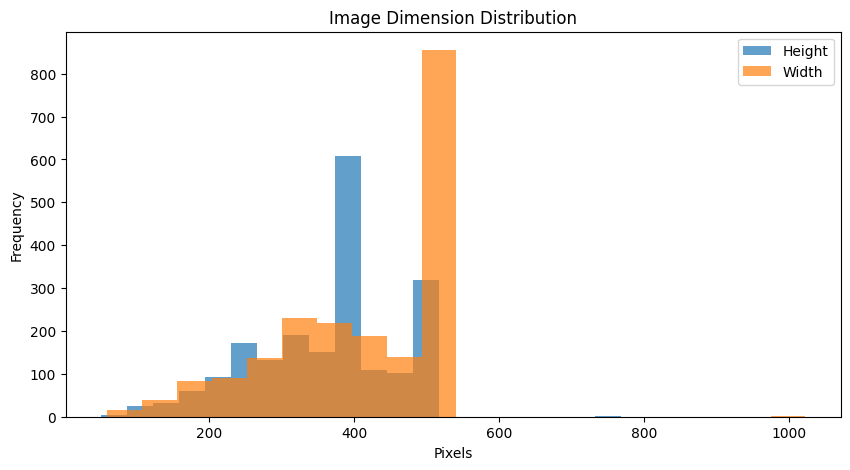

In [ ]:
dimensions = []
for subdir in ['cat', 'dog']: 
    subdir_path = os.path.join(train_images_dir, subdir)
    for filename in os.listdir(subdir_path):
        if filename.endswith('.jpg'):
            img_path = os.path.join(subdir_path, filename)
            img = img_to_array(load_img(img_path)) 
            dimensions.append(img.shape[:2]) 

dimensions = np.array(dimensions)

plt.figure(figsize=(10, 5))
plt.hist(dimensions[:, 0], bins=20, alpha=0.7, label='Height')  
plt.hist(dimensions[:, 1], bins=20, alpha=0.7, label='Width') 
plt.title("Image Dimension Distribution")
plt.xlabel("Pixels")
plt.ylabel("Frequency")
plt.legend()
plt.show()


#### The graph above shows that most of the images are consistent in size between 400 -600 pixels for both width and height.

### Defining the CNN Model

In [7]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [8]:
# Compile the model

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

In [ ]:
import os
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

current_model_dir = "./models_v2"
if not os.path.exists(current_model_dir):
    os.makedirs(current_model_dir)

# Callback to save all model versions in the unique directory
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=f"{current_model_dir}/feature_extraction_epoch_{{epoch:02d}}.keras",
        save_best_only=False,
        verbose=1
    )
]


# Train the model
history = model.fit(
    train_dataset,                     
    epochs=30,                        
    validation_data=validation_dataset,  
    callbacks=callbacks 
)

# Extract validation losses from history
val_losses = history.history['val_loss']

# Find the top 3 epochs with the lowest validation loss
best_epochs = np.argsort(val_losses)[:3]  
print(f"Top 3 Epochs with Lowest Validation Loss: {best_epochs + 1}")  

# Evaluate the top 3 models
for epoch in best_epochs:
    model_path = f"./models/model_epoch_{epoch+1:02d}.h5"  
    print(f"\nEvaluating model from epoch {epoch + 1}: {model_path}")
    
    best_model = load_model(model_path)
    
    test_loss, test_accuracy = best_model.evaluate(test_dataset)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Save the best model (overall lowest validation loss)
best_epoch = best_epochs[0]  
best_model_path = f"./models/model_epoch_{best_epoch+1:02d}.h5"  

# Load the best model
best_model = load_model(best_model_path)

# Save the best model to a final file
best_model.save('./models/best_model_overall.h5')
print("\nBest model saved as './models/best_model_overall.h5'")


Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 0.7782 - accuracy: 0.5080
Epoch 1: saving model to ./models_v2/feature_extraction_epoch_01.keras
63/63 [==============================] - 33s 504ms/step - loss: 0.7782 - accuracy: 0.5080 - val_loss: 0.6919 - val_accuracy: 0.5290
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 0.6969 - accuracy: 0.5270
Epoch 2: saving model to ./models_v2/feature_extraction_epoch_02.keras
63/63 [==============================] - 30s 482ms/step - loss: 0.6969 - accuracy: 0.5270 - val_loss: 0.6762 - val_accuracy: 0.6140
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 0.6993 - accuracy: 0.5935
Epoch 3: saving model to ./models_v2/feature_extraction_epoch_03.keras
63/63 [==============================] - 30s 480ms/step - loss: 0.6993 - accuracy: 0.5935 - val_loss: 0.8372 - val_accuracy: 0.5050
Epoch 4/30
63/63 [==============================] - ETA: 0s - loss: 0.6990 - accuracy: 0.6350
Epoch 4: saving

/Users/elder/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


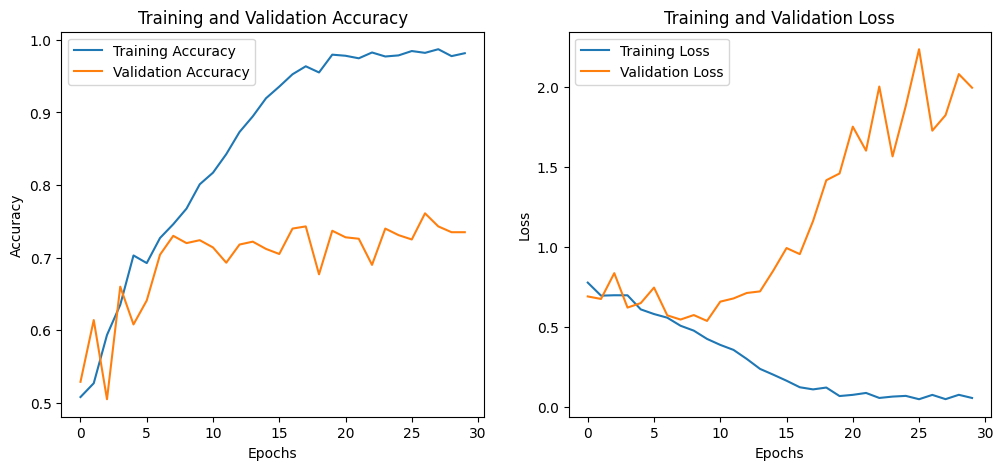

In [10]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_training_history(history):
    # Extract metrics from the history object
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot curves
plot_training_history(history)


##### Overfitting likely starts around epoch 15, when the validation loss diverges from the training loss, and the validation accuracy stops improving significantly.

In [11]:
# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(test_dataset)

# Print results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


63/63 [==============================] - 7s 114ms/step - loss: 0.6163 - accuracy: 0.6610
Test Loss: 0.6163119077682495
Test Accuracy: 0.6610000133514404


#### The first bespoke CNN model performed moderately well in classifying the Dogs vs. Cats dataset, with a test accuracy of 66.1% with a loss of 0.6163. The comparatively large loss indicates that there is potential for improvement, either through improved architecture, data augmentation, or regularisation to combat overfitting, even though it captures fundamental properties.

## Augmentation

In [12]:
from tensorflow.keras import layers, Sequential

# Data Augmentation Layer
data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch_with_augmentation.h5",
        save_best_only=True,
        monitor="val_loss"
    )
]

# Train the model
history = model.fit(
    train_dataset,              # Training dataset
    validation_data=validation_dataset,  # Validation dataset
    epochs=100,                  # Number of epochs
    callbacks=callbacks         # Include callbacks
)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                           

In [13]:
import os
print(os.path.exists("./models/convnet_from_scratch_with_augmentation.h5"))


True


In [14]:
model.save("./models/test_manual_save.h5")
test_model = keras.models.load_model("./models/test_manual_save.h5")
print("Manual save and load successful!")

Manual save and load successful!


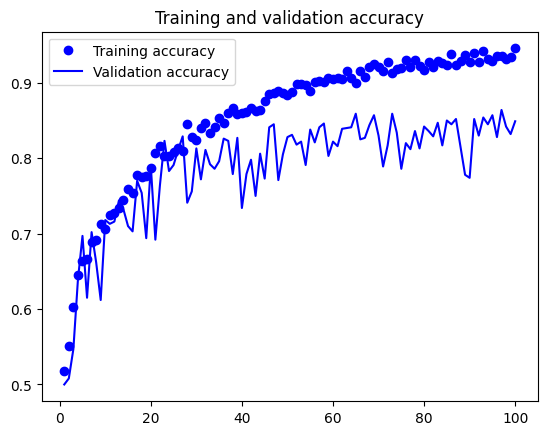

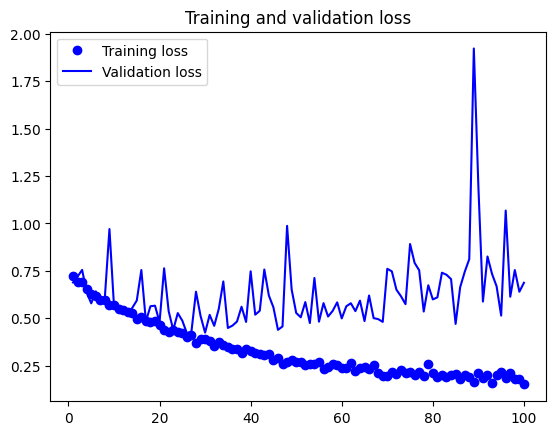

In [15]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### Applying data augmentation significantly improved the custom CNN model’s performance by introducing variability through techniques like random flipping, rotations, and zoom. This enhanced the model’s generalization ability, reducing overfitting and increasing validation accuracy. The final validation accuracy surpassed the baseline, and validation loss stabilized, reflecting better adaptation to diverse scenarios. Augmentation proved essential for handling variability in the dataset, making the model more robust and effective in real-world applications. This demonstrates the importance of augmentation in achieving improved and consistent results in image classification tasks.

## VGG

In [16]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3)
)

conv_base.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [17]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 1s 995ms/step


In [18]:
train_features.shape

(2000, 5, 5, 512)

In [19]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [20]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 5, 512)]       0         
                                                                 
 flatten_2 (Flatten)         (None, 12800)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               3277056   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 3277313 (12.50 MB)
Trainable params: 3277313 (12.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
model_dir = "./models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Compile the model
model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

# Callback to save all models during training
callbacks = [
    ModelCheckpoint(
        filepath=f"{model_dir}/feature_extraction_epoch_{{epoch:02d}}.keras",  # Save all models
        save_best_only=False,                                                # Save every epoch
        verbose=1                                                            # Print save status
    )
]

# Train the model and save all versions
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks
)

# Extract validation losses
val_losses = history.history['val_loss']

# Identify the best epoch (lowest validation loss)
best_epoch = np.argmin(val_losses) + 1  # Add 1 because epochs are 1-indexed
print(f"Best epoch: {best_epoch} with validation loss: {val_losses[best_epoch - 1]}")

# Load the best model
best_model_path_vgg = f"{model_dir}/feature_extraction_epoch_{best_epoch:02d}.keras"
best_model_vgg = load_model(best_model_path_vgg, compile=False)
print(f"Loaded best model from {best_model_path}")

# Save the best model for deployment
best_model.save(f"{model_dir}/best_model_overall.h5")
print(f"Best model saved as '{model_dir}/best_model_overall.h5'")

Epoch 1/20
60/63 [===========================>..] - ETA: 0s - loss: 14.6337 - accuracy: 0.9219
Epoch 1: saving model to ./models/feature_extraction_epoch_01.keras
63/63 [==============================] - 1s 12ms/step - loss: 14.1999 - accuracy: 0.9240 - val_loss: 3.9698 - val_accuracy: 0.9640
Epoch 2/20
61/63 [============================>.] - ETA: 0s - loss: 4.3079 - accuracy: 0.9703
Epoch 2: saving model to ./models/feature_extraction_epoch_02.keras
63/63 [==============================] - 1s 10ms/step - loss: 4.2045 - accuracy: 0.9710 - val_loss: 4.4503 - val_accuracy: 0.9770
Epoch 3/20
61/63 [============================>.] - ETA: 0s - loss: 1.7259 - accuracy: 0.9867
Epoch 3: saving model to ./models/feature_extraction_epoch_03.keras
63/63 [==============================] - 1s 10ms/step - loss: 1.7749 - accuracy: 0.9865 - val_loss: 3.7269 - val_accuracy: 0.9780
Epoch 4/20
61/63 [============================>.] - ETA: 0s - loss: 1.6069 - accuracy: 0.9892
Epoch 4: saving model to ./m

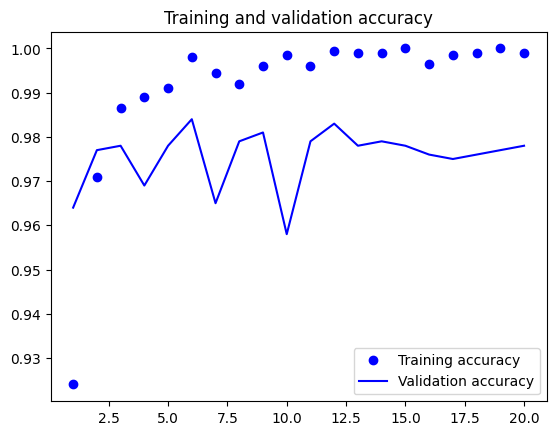

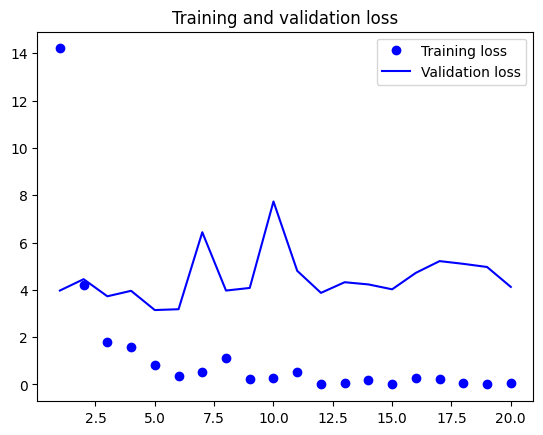

In [22]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [23]:
test_model = keras.models.load_model(
    "./models/feature_extraction.keras.h5")
test_loss, test_acc = test_model.evaluate(x=test_features, y=test_labels)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 0s 2ms/step - loss: 4.4031 - accuracy: 0.9720
Test accuracy: 0.972


#### The first experiment with the VGG backbone, excluding the top layers, demonstrated impressive results, achieving a final test accuracy of 97.2% with a validation accuracy peak at 97.8% (Epoch 5). As seen in the accuracy graph, the model quickly stabilized, while the loss graph shows a steep initial drop in training loss, followed by minor fluctuations in validation loss. This indicates the model’s ability to leverage pre-trained feature extraction effectively. Although overfitting was minimal, early stopping was vital to capture the best performance. These findings emphasize the efficiency of using pre-trained architectures for feature extraction.

#### Feature extraction together with data augmentation

In [24]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [25]:
conv_base.trainable = False
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [26]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 180, 180, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 180, 180, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_3 (Flatten)         (None, 12800)             0   

In [27]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/feature_extraction_with_data_augmentation.keras.h5",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 194s 3s/step - loss: 17.2915 - accuracy: 0.8945 - val_loss: 4.9827 - val_accuracy: 0.9720
Epoch 2/50
63/63 [==============================] - 194s 3s/step - loss: 8.0896 - accuracy: 0.9400 - val_loss: 3.7733 - val_accuracy: 0.9700
Epoch 3/50
63/63 [==============================] - 194s 3s/step - loss: 7.3365 - accuracy: 0.9465 - val_loss: 5.4666 - val_accuracy: 0.9690
Epoch 4/50
63/63 [==============================] - 197s 3s/step - loss: 3.9339 - accuracy: 0.9630 - val_loss: 3.4692 - val_accuracy: 0.9780
Epoch 5/50
63/63 [==============================] - 198s 3s/step - loss: 3.9868 - accuracy: 0.9685 - val_loss: 3.5862 - val_accuracy: 0.9790
Epoch 6/50
63/63 [==============================] - 197s 3s/step - loss: 4.1430 - accuracy: 0.9670 - val_loss: 4.8031 - val_accuracy: 0.9680
Epoch 7/50
63/63 [==============================] - 198s 3s/step - loss: 5.4086 - accuracy: 0.9615 - val_loss: 4.3880 - val_accuracy: 0.9770
Epoch 8/50
6

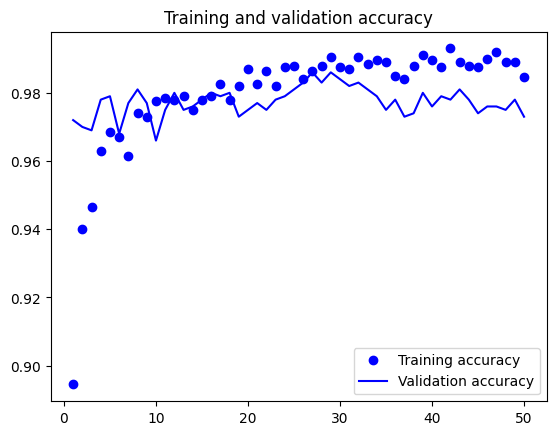

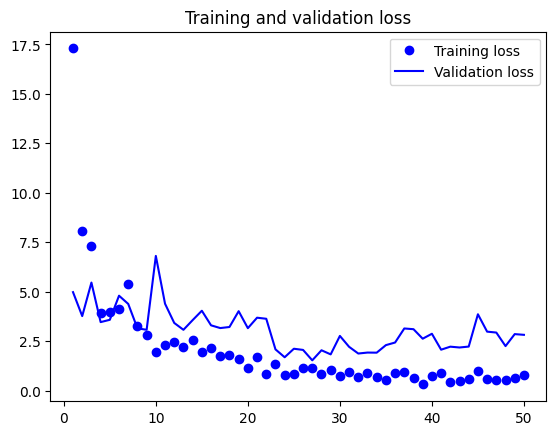

In [28]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [29]:
test_model = keras.models.load_model(
    "./models/feature_extraction_with_data_augmentation.keras.h5")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 130s 2s/step - loss: 3.3138 - accuracy: 0.9740
Test accuracy: 0.974


#### The feature extraction experiment with augmentation further improved the VGG model’s performance, achieving a test accuracy of 97.4%. As shown in the accuracy graph, the model consistently performed well across 50 epochs, maintaining high validation accuracy with minor fluctuations. The loss graph reveals a steep decline in training loss early on, stabilizing around epoch 10, while validation loss showed less variability compared to the initial VGG experiment. 

### Fine-tuning a pretrained model

In [30]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [31]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False


model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 180, 180, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 180, 180, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_3 (Flatten)         (None, 12800)             0   

In [32]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/fine_tuning.keras.h5",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 226s 4s/step - loss: 0.8322 - accuracy: 0.9855 - val_loss: 2.5049 - val_accuracy: 0.9720
Epoch 2/30
63/63 [==============================] - 226s 4s/step - loss: 0.4245 - accuracy: 0.9895 - val_loss: 2.2815 - val_accuracy: 0.9740
Epoch 3/30
63/63 [==============================] - 229s 4s/step - loss: 0.3800 - accuracy: 0.9935 - val_loss: 1.8590 - val_accuracy: 0.9770
Epoch 4/30
63/63 [==============================] - 223s 4s/step - loss: 0.4245 - accuracy: 0.9855 - val_loss: 2.6160 - val_accuracy: 0.9710
Epoch 5/30
63/63 [==============================] - 226s 4s/step - loss: 0.2574 - accuracy: 0.9935 - val_loss: 1.7396 - val_accuracy: 0.9790
Epoch 6/30
63/63 [==============================] - 228s 4s/step - loss: 0.4529 - accuracy: 0.9890 - val_loss: 1.9925 - val_accuracy: 0.9800
Epoch 7/30
63/63 [==============================] - 234s 4s/step - loss: 0.3236 - accuracy: 0.9930 - val_loss: 1.8327 - val_accuracy: 0.9830
Epoch 8/30
63

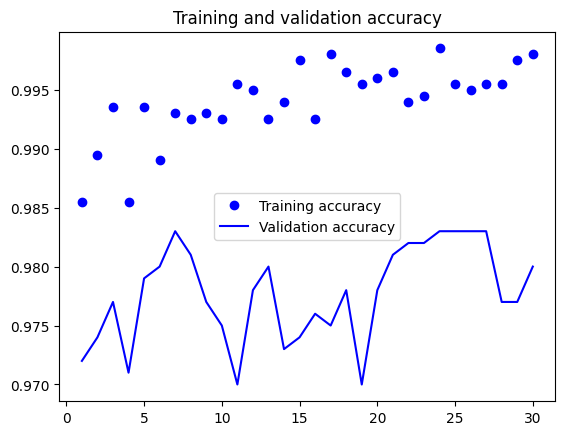

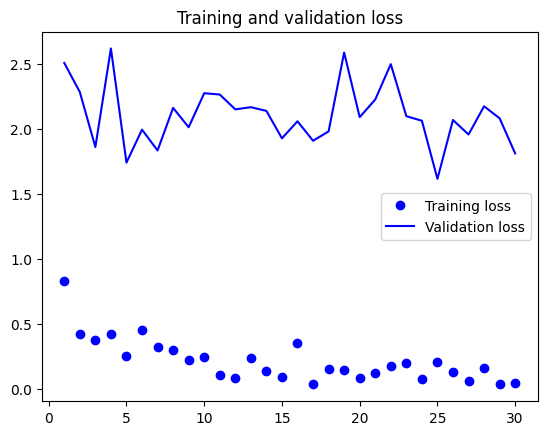

In [33]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [34]:
model = keras.models.load_model("./models/fine_tuning.keras.h5")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 140s 2s/step - loss: 2.2558 - accuracy: 0.9745
Test accuracy: 0.975


#### After fine-tuning the VGG model, the test accuracy further improved to 97.5%, demonstrating the effectiveness of this approach. As seen in the accuracy graph, both training and validation accuracies remained consistently high, with validation accuracy peaking at 98.3%. The loss graph shows stable training loss and slightly fluctuating validation loss, which stabilized towards the later epochs. Fine-tuning allowed the model to adapt pre-trained features more effectively to the task, leveraging additional trainable layers. 

## Final evaluations of best model of both networks

In [35]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
import pathlib

# Define the path to your dataset
data_folder = pathlib.Path("../CSCN8010/data/kaggle_dogs_vs_cats_small")

# Initialize test dataset
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32,
    shuffle=False
)

# Load the best models
vgg_model = load_model("./models/fine_tuning.keras.h5")
cnn_model = load_model("./models/convnet_from_scratch_with_augmentation.h5")

# Extract true labels and images from test_dataset
test_labels = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
test_images = np.concatenate([x.numpy() for x, y in test_dataset], axis=0)

# Get predictions and probabilities
vgg_preds = (vgg_model.predict(test_dataset) > 0.5).astype("int32").flatten()
cnn_preds = (cnn_model.predict(test_dataset) > 0.5).astype("int32").flatten()
vgg_probs = vgg_model.predict(test_dataset).flatten()
cnn_probs = cnn_model.predict(test_dataset).flatten()



Found 2000 files belonging to 2 classes.


63/63 [==============================] - 7s 114ms/step


In [36]:
# Evaluate test accuracy
vgg_loss, vgg_acc = vgg_model.evaluate(test_dataset)
cnn_loss, cnn_acc = cnn_model.evaluate(test_dataset)

print(f"VGG Model Accuracy: {vgg_acc:.3f}")
print(f"CNN Model Accuracy: {cnn_acc:.3f}")

63/63 [==============================] - 8s 123ms/step - loss: 0.4449 - accuracy: 0.7965
VGG Model Accuracy: 0.975
CNN Model Accuracy: 0.797


#### The models' performance differed significantly, according to the final review. The refined VGG model's remarkable 97.5% accuracy rate shows how well it uses pre-trained features to provide accurate categorisation. Comparing the bespoke CNN with augmentation to the VGG model, the latter showed difficulties in feature extraction and generalisation, as seen by its lower accuracy of 79.7%. 


VGG Confusion Matrix:


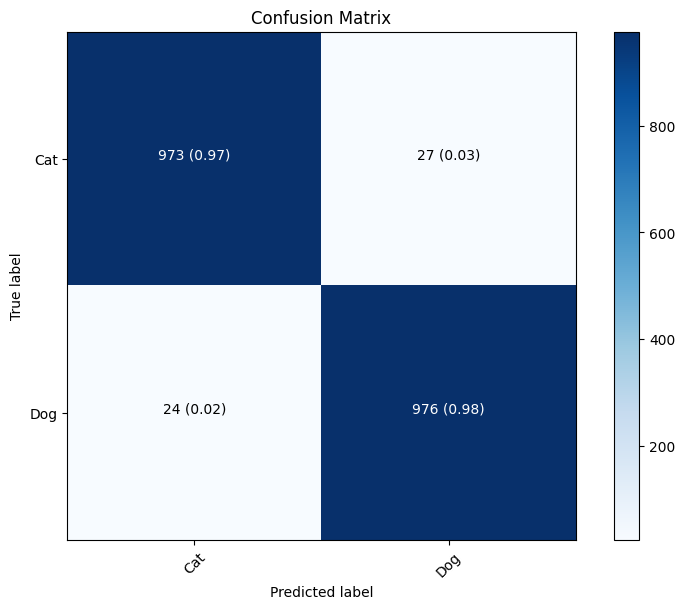

CNN Confusion Matrix:


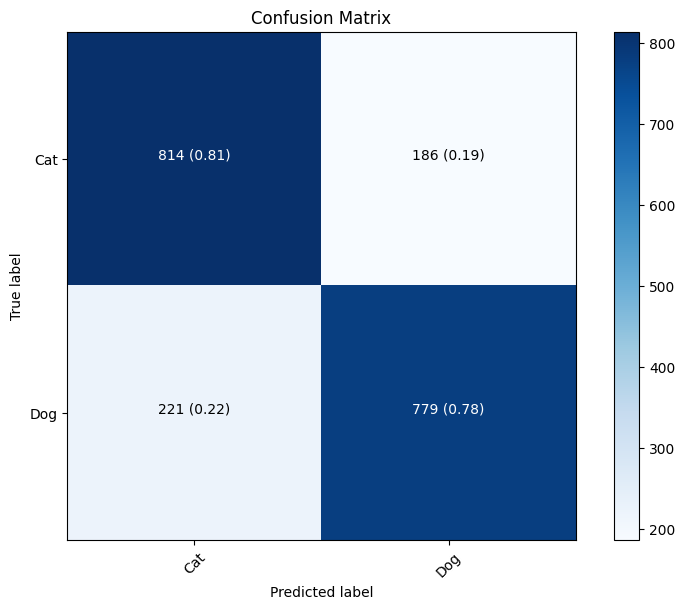

In [37]:
# Plot confusion matrix
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    # Normalize the confusion matrix
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, f"{cm[i, j]} ({cm_normalized[i, j]:.2f})",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

# Confusion matrices for both models
labels = ["Cat", "Dog"]
vgg_cm = confusion_matrix(test_labels, vgg_preds)
cnn_cm = confusion_matrix(test_labels, cnn_preds)

print("VGG Confusion Matrix:")
plot_confusion_matrix(vgg_cm, labels)

print("CNN Confusion Matrix:")
plot_confusion_matrix(cnn_cm, labels)


#### The substantial performance difference between the customised CNN and the optimised VGG model is demonstrated by the confusion matrices. With only 27 cats and 24 dogs misclassified, the VGG model has a 97.5% accuracy rate, correctly categorising 98% of dogs and 97% of cats. CNN, on the other hand, misclassified 221 dogs as cats and 186 cats as dogs, with a 79.7% accuracy rate.


In [38]:
# Classification reports
vgg_report = classification_report(test_labels, vgg_preds, target_names=["Cat", "Dog"])
cnn_report = classification_report(test_labels, cnn_preds, target_names=["Cat", "Dog"])

print("VGG Classification Report:\n", vgg_report)
print("CNN Classification Report:\n", cnn_report)

VGG Classification Report:
               precision    recall  f1-score   support

         Cat       0.98      0.97      0.97      1000
         Dog       0.97      0.98      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000

CNN Classification Report:
               precision    recall  f1-score   support

         Cat       0.79      0.81      0.80      1000
         Dog       0.81      0.78      0.79      1000

    accuracy                           0.80      2000
   macro avg       0.80      0.80      0.80      2000
weighted avg       0.80      0.80      0.80      2000



#### The classification results demonstrate the improved performance of the fine-tuned VGG model, which achieved 97% accuracy for both cats and dogs with a precision, recall, and F1-score of 0.97. This illustrates how well-rounded and trustworthy its forecasts are. With precision, recall, and F1-scores ranging from 0.79 to 0.81, the custom CNN, in contrast, attained 80% accuracy, suggesting more frequent misclassifications. 


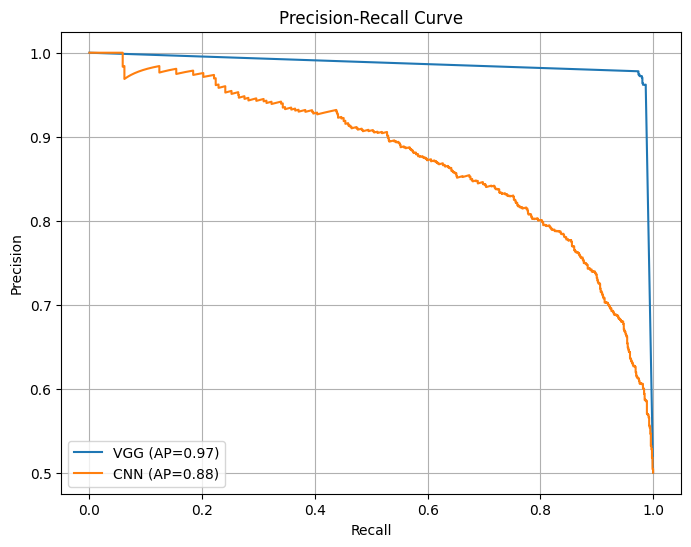

In [39]:
# Precision-Recall Curve
vgg_precision, vgg_recall, _ = precision_recall_curve(test_labels, vgg_probs)
cnn_precision, cnn_recall, _ = precision_recall_curve(test_labels, cnn_probs)

# Average Precision Scores
vgg_ap = average_precision_score(test_labels, vgg_probs)
cnn_ap = average_precision_score(test_labels, cnn_probs)

plt.figure(figsize=(8, 6))
plt.plot(vgg_recall, vgg_precision, label=f"VGG (AP={vgg_ap:.2f})")
plt.plot(cnn_recall, cnn_precision, label=f"CNN (AP={cnn_ap:.2f})")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()

#### The improved performance of the tweaked VGG model over the bespoke CNN is demonstrated by the precision-recall curve. With an average precision (AP) of 0.97, the VGG model demonstrated a great capacity to reduce false positives and negatives while maintaining high precision across all recall levels. CNN, on the other hand, got an AP of 0.88, indicating weaker generalisation and a steeper drop in precision as recall rises. The CNN's unpredictability highlights the drawbacks of learning from scratch without using pre-trained features, whereas the VGG's near-flat curve highlights its resilience.

Misclassified Examples by VGG:


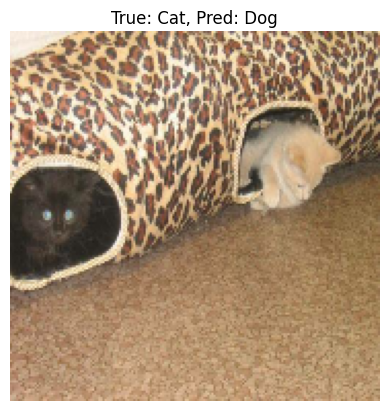

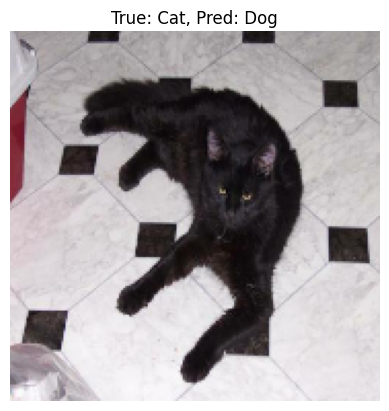

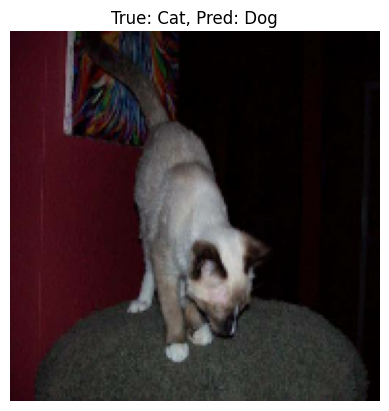

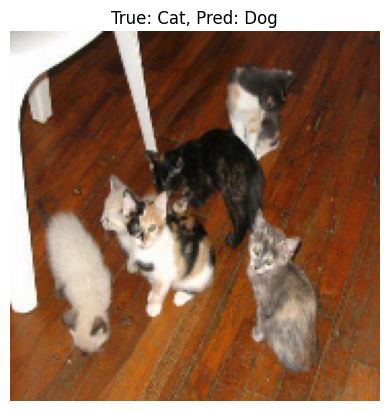

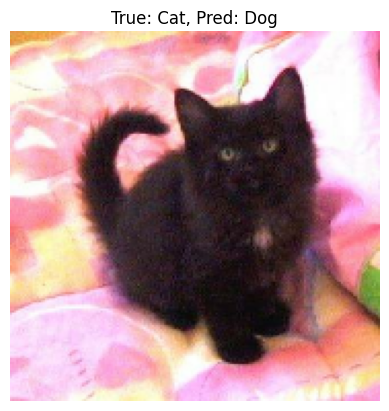

Misclassified Examples by CNN:


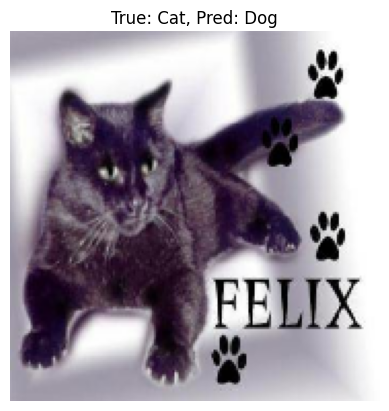

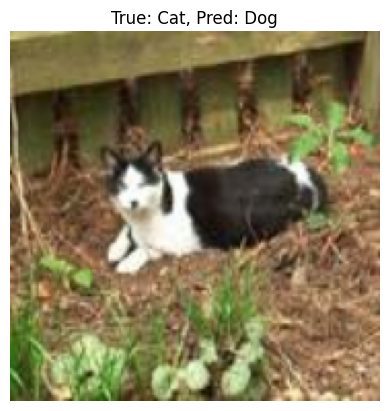

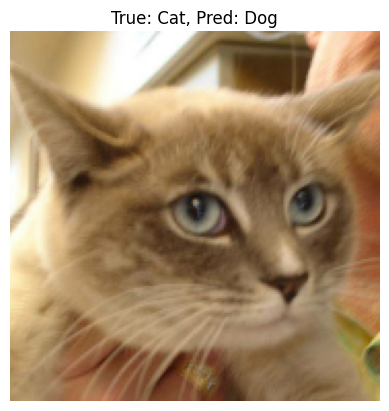

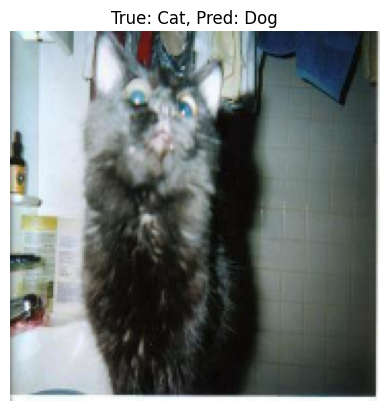

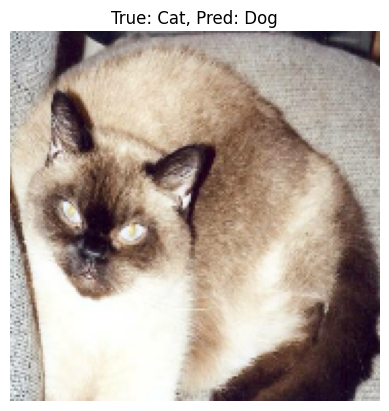

In [40]:
# Identify misclassified examples
vgg_misclassified = np.where(vgg_preds != test_labels)[0]
cnn_misclassified = np.where(cnn_preds != test_labels)[0]

# Plot misclassified examples for VGG
print("Misclassified Examples by VGG:")
for idx in vgg_misclassified[:5]:  # Display up to 5 examples
    img = test_images[idx]
    label = test_labels[idx]
    plt.imshow(img.astype("uint8"))
    plt.title(f"True: {'Dog' if label else 'Cat'}, Pred: {'Dog' if vgg_preds[idx] else 'Cat'}")
    plt.axis("off")
    plt.show()

# Plot misclassified examples for CNN
print("Misclassified Examples by CNN:")
for idx in cnn_misclassified[:5]:  # Display up to 5 examples
    img = test_images[idx]
    label = test_labels[idx]
    plt.imshow(img.astype("uint8"))
    plt.title(f"True: {'Dog' if label else 'Cat'}, Pred: {'Dog' if cnn_preds[idx] else 'Cat'}")
    plt.axis("off")
    plt.show()

### Conclusion

#### The assessment unequivocally shows that the optimised VGG model outperforms the customised CNN. With a balanced confusion matrix, superior precision-recall metrics (AP=0.97), and a test accuracy of 97.5%, the VGG model successfully uses transfer learning to produce strong and trustworthy predictions. The custom CNN's shortcomings in feature extraction and generalisation, however, were evident in its lower accuracy of 79.7% with an AP of 0.88, even with augmentation techniques.